In [0]:
#!mv "./Assignment 5 Dataset" "./drive/My Drive/"
from google.colab import drive
drive.mount('/content/drive')

In [0]:
! unzip './drive/My Drive/A_05_Part_02_Dataset.zip'

In [3]:
import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import natsort
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns 
import time
import os
import copy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_dir = 'A_05_Part_02_Dataset'
batch_size = 120

In [5]:
#Define transforms for the training data and validation data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),                             
                                      transforms.ToTensor()])


#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform = train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/Validation', transform = valid_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print('Train',class_names)

valid_class_names = valid_data.classes
print('Validation',valid_class_names)

Classes: 
Train ['covid-19', 'normal', 'pneumonia']
Validation ['covid', 'normal', 'pneumonia']


In [6]:
len(trainloader.dataset), len(validloader.dataset)

(6200, 628)

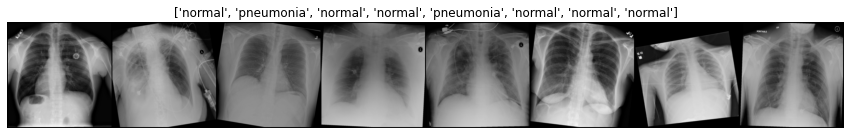

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs[:8])
    imshow(out, title=[class_names[x] for x in classes[:8]])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
def one_hot_label(inp, num_classes):
    # 0: Covid class, 1: Normal class, 2: Pneumunia class
    vector = np.zeros((len(inp), num_classes))
    for i, label in enumerate(inp):
      if label == 0:
        vector[i][0] = 1
        vector[i][2] = 1
      elif label == 1:
        vector[i][1] = 1
      elif label == 2:
        vector[i][2] = 1
    return torch.FloatTensor(vector)

In [0]:
def get_model(name, pretrain):
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrain)
        
        num_features = model.classifier[6].in_features
        features = list(model.classifier.children())[:-1]
        num_features = model.classifier[5]
        features = list(model.classifier.children())[:-2]
        num_features = model.classifier[4]
        features = list(model.classifier.children())[:-3]
        num_features = model.classifier[3].in_features
        features = list(model.classifier.children())[:-4]
        num_features = model.classifier[2]
        features = list(model.classifier.children())[:-5] 
        num_features = model.classifier[1]
        features = list(model.classifier.children())[:-6] 
        num_features = model.classifier[0]
        features = list(model.classifier.children())[:-7]

        for param in model.features.parameters():
            param.requires_grad = True 

        n_inputs = 25088
        model.classifier = nn.Sequential(
            nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.55),
            nn.Linear(2048, len(class_names)))

    elif name == 'resnet18':
        model = models.resnet18(pretrained=pretrain)
        
        features_num = model.fc
        resnet_feature = list(model.fc.children())[:0]

        for param in model.layer1.parameters():
            param.requires_grad = True
        for param in model.layer2.parameters():
            param.requires_grad = True
        for param in model.layer3.parameters():
            param.requires_grad = True
        for param in model.layer4.parameters():
            param.requires_grad = True
        for param in model.fc.parameters():
            param.requires_grad = True
        
        n_inputs = 512
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 2048), nn.ReLU(), nn.Dropout(0.50),
            nn.Linear(2048, len(class_names)))

    # get gpu
    if gpu: model = model.to('cuda')
    else: model = model.to('cpu')
    
    return model

In [0]:
def plotCurves(stats):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and Validation Loss Curve')

    plt.figure(figsize=(8, 6))
    for c in ['train_acc', 'valid_acc']:
        plt.plot(100 * stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curve')
    plt.show()

In [0]:
class Focal_Loss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, logits=False, sampling=None):
        super(Focal_Loss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.sampling = sampling

    def forward(self, y_pred, y_true):
        alpha = self.alpha
        alpha_ = (1-self.alpha)
        if self.logits: y_pred = torch.sigmoid(y_pred)
        
        pt_positive = torch.where(y_true==1, y_pred, torch.ones_like(y_pred))
        pt_negative = torch.where(y_true==0, y_pred, torch.zeros_like(y_pred)) 
        pos_ = (1-pt_positive) ** self.gamma
        neg_ = (pt_negative) ** self.gamma
        
        pos_loss = -alpha * pos_ * torch.log(pt_positive) 
        neg_loss = -alpha_ * neg_ * torch.log(1 - pt_negative) 
        loss = pos_loss + neg_loss 
        
        if self.sampling == "mean": return loss.mean()
        elif self.sampling == "sum": return loss.sum()
        elif self.sampling == None: return loss 

In [12]:
# Check if gpu is available
gpu = cuda.is_available()
print('Gpu is available:',gpu)

Gpu is available: True


In [13]:
model = get_model('resnet18', True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [14]:
from torchsummary import summary
summary(model, (3, 224, 224), batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [120, 64, 112, 112]           9,408
       BatchNorm2d-2        [120, 64, 112, 112]             128
              ReLU-3        [120, 64, 112, 112]               0
         MaxPool2d-4          [120, 64, 56, 56]               0
            Conv2d-5          [120, 64, 56, 56]          36,864
       BatchNorm2d-6          [120, 64, 56, 56]             128
              ReLU-7          [120, 64, 56, 56]               0
            Conv2d-8          [120, 64, 56, 56]          36,864
       BatchNorm2d-9          [120, 64, 56, 56]             128
             ReLU-10          [120, 64, 56, 56]               0
       BasicBlock-11          [120, 64, 56, 56]               0
           Conv2d-12          [120, 64, 56, 56]          36,864
      BatchNorm2d-13          [120, 64, 56, 56]             128
             ReLU-14          [120, 64,

In [0]:
# hyper-parameters initialization
Epochs = 300
#criterion = nn.BCEWithLogitsLoss()
FL = Focal_Loss(alpha=0.25, gamma=2, logits=True, sampling='mean')
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Training Started.......

Epoch 0 : Training Loss: 0.055653, Training Accuracy: 68.677%
	  Validation Loss: 0.051028, Validation Accuracy: 66.773%
	  F1: 0.100575


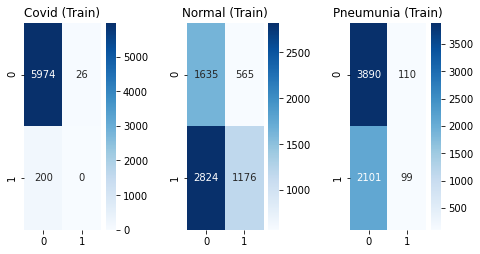

<Figure size 288x360 with 0 Axes>

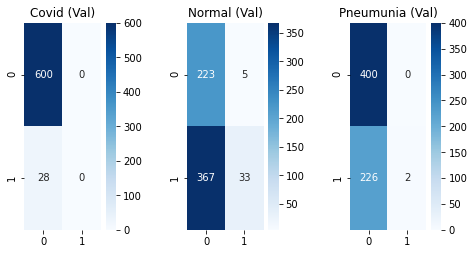

<Figure size 288x360 with 0 Axes>

KeyboardInterrupt: ignored

In [16]:
device = torch.device("cuda")

model.to(device)
model.train()
stats = []

print('Training Started.......')
for epoch in range(Epochs): 

    train_acc = 0.0
    valid_acc = 0.0
    train_loss = 0.0
    valid_loss = 0.0   
    train_pred, train_orig, valid_pred, valid_orig = [], [], [], []

    # Training dataset pass
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data
        labels = one_hot_label(labels, len(class_names))
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        out = torch.sigmoid(outputs)
        #loss = criterion(outputs, labels) 
        loss = FL.forward(outputs, labels)
        loss.backward()                    
        optimizer.step()                 

        # print statistics
        train_loss += loss.item() * inputs.size(0)

        # Calculate train accuracy and thresholding
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(out > thresh, one, zero)
        
        correct_tensor = predicted.eq(labels.data.view_as(predicted))
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        train_acc += accuracy.item() * inputs.size(0)

        train_pred.extend(predicted.cpu().numpy())
        train_orig.extend(labels.cpu().numpy())

    train_loss = train_loss / len(trainloader.dataset)
    train_acc = train_acc / len(trainloader.dataset)

    # We don't need to save grads because no backprop is required for validation set
    with torch.no_grad():
        model.eval()
        # Validation dataset pass
        for i, data in enumerate(validloader):
            # get the inputs
            inputs, labels = data
            labels = one_hot_label(labels, len(class_names))
            inputs, labels = inputs.to(device), labels.to(device)

            # Validation loss
            outputs = model(inputs) 
            out = torch.sigmoid(outputs)
            #loss = criterion(outputs, labels)
            loss = FL.forward(outputs, labels)
            valid_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy and thresholding
            thresh = Variable(torch.Tensor([0.50])).to(device)
            one = Variable(torch.Tensor([1])).to(device)
            zero = Variable(torch.Tensor([0])).to(device)
            predicted = torch.where(out > thresh, one, zero)

            correct_tensor = predicted.eq(labels.data.view_as(predicted))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            valid_acc += accuracy.item() * inputs.size(0)

            valid_pred.extend(predicted.cpu().numpy())
            valid_orig.extend(labels.cpu().numpy())

        valid_loss = valid_loss / len(validloader.dataset)
        valid_acc = valid_acc / len(validloader.dataset)

        model.optimizer = optimizer
        stats.append([train_loss, valid_loss, train_acc, valid_acc])
    
    print('\nEpoch',epoch,':',f'Training Loss: {train_loss:.6f},',f'Training Accuracy: {100 * train_acc:.3f}%')
    print(f'\t  Validation Loss: {valid_loss:.6f},',f'Validation Accuracy: {100 * valid_acc:.3f}%')
    f1 = f1_score(np.array(valid_orig), np.array(valid_pred), average='micro')
    print(f'\t  F1: {f1:.6f}')

    # Plot Confusion matrices after some epochs
    if epoch % 7 == 0:
        train_cm = multilabel_confusion_matrix(np.array(train_orig), np.array(train_pred))
        valid_cm = multilabel_confusion_matrix(np.array(valid_orig), np.array(valid_pred))

        fig, ax =plt.subplots(1,3)
        plt.figure(figsize=(4,5))
        fig.tight_layout(pad=3.0)
        fig.subplots_adjust(left = 0.025, right = 1, wspace=.7)
        sns.heatmap(train_cm[0], annot=True, cmap='Blues', fmt="d", ax=ax[0])
        sns.heatmap(train_cm[1], annot=True, cmap='Blues', fmt="d", ax=ax[1])
        sns.heatmap(train_cm[2], annot=True, cmap='Blues', fmt="d", ax=ax[2])
        ax[0].set_title('Covid (Train)')
        ax[1].set_title('Normal (Train)')
        ax[2].set_title('Pneumunia (Train)')
        plt.show()

        fig1, ax1 =plt.subplots(1,3)
        plt.figure(figsize=(4,5))
        fig1.tight_layout(pad=3.0)
        fig1.subplots_adjust(left = 0.025, right = 1, wspace=.7)
        sns.heatmap(valid_cm[0], annot=True, cmap='Blues', fmt="d", ax=ax1[0])
        sns.heatmap(valid_cm[1], annot=True, cmap='Blues', fmt="d", ax=ax1[1])
        sns.heatmap(valid_cm[2], annot=True, cmap='Blues', fmt="d", ax=ax1[2])
        ax1[0].set_title('Covid (Val)')
        ax1[1].set_title('Normal (Val)')
        ax1[2].set_title('Pneumunia (Val)')
        plt.show()

    stat = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
    torch.save(model, './drive/My Drive/FINALwith_focalloss_resnet18.pth')


print('Finished Training')
plotCurves(stat)

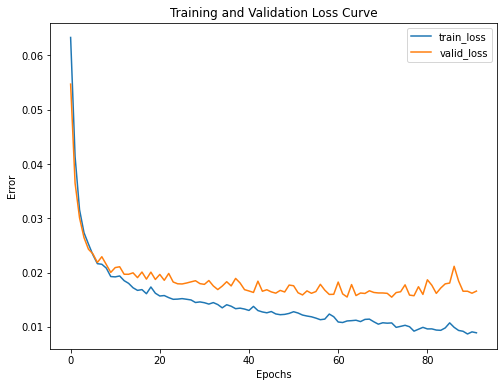

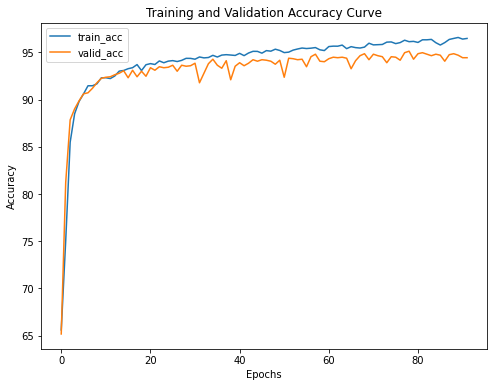

In [14]:
plotCurves(stat)

In [0]:
stat.to_csv('./drive/My Drive/finalPLOT2.csv')

Test data predictions

In [0]:
# Load the trained model
#model = torch.load('./drive/My Drive/Covid_focal_loss_weights/res18_focal_loss.pth')

In [0]:
class TestDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return img_loc, tensor_image

In [0]:
test_transforms = transforms.Compose([transforms.Resize((224,244), 2),
                                      transforms.ToTensor()])

test_dataset = TestDataSet(data_dir + "/Test/", transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [0]:
# Prediction on Test dataset
device = torch.device("cuda")
model = model.to(device)
pred, names = [], []
with torch.no_grad():
    model.eval()
    # Test dataset pass
    for i, data in enumerate(testloader):
        # get the inputs
        name, inputs = data
        inputs = inputs.to(device)

        outputs = model(inputs) 
        outs = nn.Sigmoid()
        out = outs(outputs)

        #Predicting labels
        thresh = Variable(torch.Tensor([0.50])).to(device)
        one = Variable(torch.Tensor([1])).to(device)
        zero = Variable(torch.Tensor([0])).to(device)
        predicted = torch.where(out > thresh, one, zero)
        pred.extend(predicted.data.cpu().numpy().astype(int))
        names.extend(name)

In [0]:
img = pd.DataFrame(names, columns=['image name'])

In [0]:
label = pd.DataFrame(pred, columns=['Covid Class', 'Normal Class', 'Pneumunia Class'])

In [0]:
csv = pd.concat([img, label], axis=1)

In [0]:
columns_titles = ["image name", "Covid Class", "Pneumunia Class", "Normal Class"]
csv = csv.reindex(columns=columns_titles)
csv.head(10)

In [0]:
csv.to_csv('./drive/My Drive/FINAL.csv')